In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
connection = {
    #тут информация о подключении - хост, База данных, логин и пароль
}


In [15]:
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(query, connection=connection)



In [20]:
print(df[df.exp_group == 1]['ctr'].sum())
print(df[df.exp_group == 2]['ctr'].sum())

2173.0787474042527
2133.9006096211474


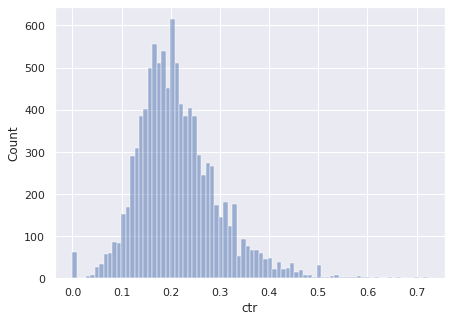

In [36]:
sns.set(rc={'figure.figsize':(7,5)})

groups = sns.histplot(data = df[df.exp_group == 1]['ctr'], 
              alpha=0.5,
              kde=False)

Распределение ctr в группе 2 нельзя назвать нормальным, т-тест не подходит


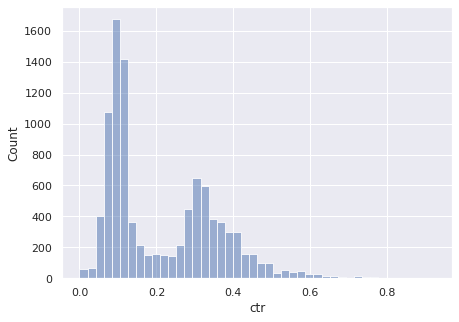

In [28]:
sns.set(rc={'figure.figsize':(7, 5)})

groups = sns.histplot(data = df[df.exp_group == 2]['ctr'], 
              alpha=0.5,
              kde=False)
print(f'Распределение ctr в группе 2 нельзя назвать нормальным, т-тест лучше не использовать')

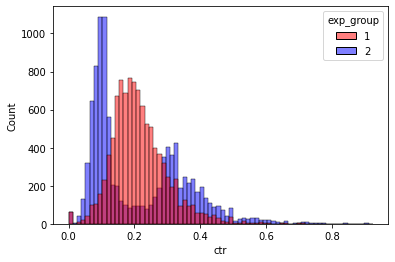

In [8]:
#строим график, для визуальной проверки
#кажется, будто выборки различаются
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [9]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')
print('Критерий Манна-Уитни показывает, что значения действительно различаются')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [21]:
group_1 = df[df.exp_group == 1]['ctr']
group_2 = df[df.exp_group == 2]['ctr']

In [37]:

#bootstrap
sample = 1000
boot_1 = [np.random.choice(df.group_1) for _ in range(len(sample))]
boot_2 = [np.random.choice(df.group_2) for _ in range(len(sample))]

In [56]:
#различия есть, но стоит проверить, увеличилось ли ctr, или уменьшится
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=10000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [57]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()


In [58]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

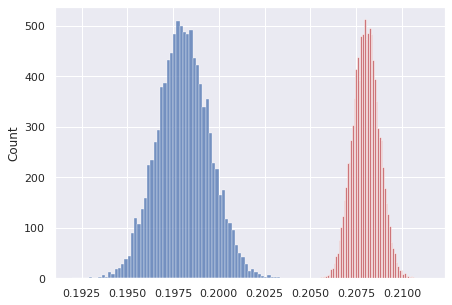

In [59]:
sns.histplot(ctr1, color='r')
sns.histplot(ctr2)

In [54]:
print('Бутстреп подтвержает различия, но после внедрения новой рекомендательной системы CTR стало меньше!!!')

Бутстреп подтвержает различия, но после внедрения новой рекомендательной системы CTR стало меньше!!!


In [66]:
print("""Использовать эту рекомендательную систему не рекомендуется, 
поскольку в среднем пользователи стали лайкать посты реже.

Почему заинтересованность уменьшилась? Из распределения ctr-видно, что оно получилось бимодальным.
У большей части пользователей ctr-снизилась, но у части, наоборот увеличилась. 
Возможно, это связано с недостаточно "обученным" алгоритмом, 
поэтому не у всех пользователей были корректные рекомендации. 
Так же, вероятно, если попадаются очень похожие посты, 
то пользователь перестает лайкать однообразный контент 
""")

Использовать эту рекомендательную систему не рекомендуется, 
поскольку в среднем пользователи стали лайкать посты реже.

Почему заинтересованность уменьшилась? Из распределения ctr-видно, что оно получилось бимодальным.
У большей части пользователей ctr-снизилась, но у части, наоборот увеличилась. 
Возможно, это связано с недостаточно "обученным" алгоритмом, 
поэтому не у всех пользователей были корректные рекомендации. 
Так же, вероятно, если попадаются очень похожие посты, 
то пользователь перестает лайкать однообразный контент 

